In [1]:
import numpy as np
import scipy.io
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
#%matplotlib inline
import torch
import torch.nn as nn
import torch.utils.data
import torchvision.transforms as transforms
from torch.autograd import Variable
import skimage as skimage
import skimage.filters
from skimage.util import invert

In [2]:
def gaussnoise(image,m,v):
    return skimage.util.random_noise(image,mode='gaussian',mean=m,var=v)
# def poissonnoise(image):
#     return skimage.util.random_noise(image,mode='poisson')
def saltpeppernoise(image):
    return skimage.util.random_noise(image,mode='s&p')
def specklenoise(image):
    return skimage.util.random_noise(image,mode='speckle')
# def gaussblurring(image,v):
#     return skimage.filters.gaussian(image,sigma=v)
# def invert(image):
#     return invert(image)

In [3]:
mat1 = scipy.io.loadmat('Val_Raw.mat')
Val_Raw = mat1['Val_Raw']

In [4]:
l,w = 45,35
Total_Val_Photo = int((Val_Raw.shape[0]*Val_Raw.shape[1])/(l*w))
Photo_Val_Col = 37
print(Total_Val_Photo)

2590


In [5]:
#Normalisasi
Val_Raw_Norm = Val_Raw/255

In [6]:
i=0
val_data_raw = np.zeros([Total_Val_Photo,l,w])
for a in range(0,int(Total_Val_Photo/Photo_Val_Col)):
    for b in range(0,Photo_Val_Col):
        val_data_raw[i,:,:] = Val_Raw_Norm[45*a:45+45*a,35*b:35+35*b]
        i=i+1
        
print(val_data_raw.shape)

(2590, 45, 35)


In [7]:
#val_data_raw = gaussnoise(val_data_raw,0,0.01)
#val_data_raw = saltpeppernoise(val_data_raw)
#val_data_raw = val_data_raw/2

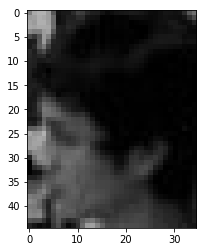

In [8]:
plt.imshow(val_data_raw[1999,:,:], cmap='gray', vmin=0, vmax=1)

In [10]:
tar = np.eye(10)
target_val = np.zeros([Total_Val_Photo,10])
for d in range(0,10):
    target_val[0+int(Total_Val_Photo/10)*d:int(Total_Val_Photo/10)+int(Total_Val_Photo/10)*d,:] = tar[d,:]
print(target_val.shape)

(2590, 10)


In [11]:
tebal_val = Total_Val_Photo
target_val3d = np.zeros(shape=(tebal_val, 1, 10))
i=0
for i in range(tebal_val):
    target_val3d[i,0,:] = target_val[i,:]

In [12]:
def val_inl4d(data):
    image_size = [45,35]
    data4d = np.zeros([Total_Val_Photo,1,image_size[0],image_size[1]])
    data4d[:,0,:,:] = data
    return data4d

def val_tarl4d(data):
    image_size = [1,10]
    data4d = np.zeros([Total_Val_Photo,1,image_size[0],image_size[1]])
    data4d[:,0,:,:] = data
    return data4d

In [13]:
input_val4d = val_inl4d(val_data_raw)
target_val4d = val_tarl4d(target_val3d)

print(input_val4d.shape)
print(target_val4d.shape)

(2590, 1, 45, 35)
(2590, 1, 1, 10)


In [14]:
device = torch.device('cuda:0')
batch_size_val = int(Total_Val_Photo/10)

In [15]:
input_val4d = torch.from_numpy(input_val4d).float().cuda()
target_val4d = torch.from_numpy(target_val4d).float().cuda()

target_val = torch.from_numpy(target_val).float().cuda()

dataset_val = torch.utils.data.TensorDataset(input_val4d, target_val)

kwargs = {}
val_loader = torch.utils.data.DataLoader(dataset_val,
                                         batch_size=batch_size_val, 
                                         shuffle=True,**kwargs)

print('There are {} images in the test set'.format(len(dataset_val)))
print('There are {} batches in the testloader'.format(len(val_loader)))

There are 2590 images in the test set
There are 10 batches in the testloader


In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 20, kernel_size=5, stride=1, padding=0),
#             nn.ReLU(),
            nn.AvgPool2d(kernel_size=5, stride=1))
        self.layer2 = nn.Sequential(
            nn.Conv2d(20, 50, kernel_size=5, stride=1, padding=0),
#             nn.ReLU(),
            nn.MaxPool2d(kernel_size=5, stride=1))
        self.fc1 = nn.Linear(29 * 19 * 50, 1000)
#         self.drop_out = nn.Dropout()
        self.act1 = nn.Tanh()
    
        self.fc2 = nn.Linear(1000, 500)
        self.act2 = nn.Tanh()
        
        self.fc3 = nn.Linear(500,10)
        self.act3 = nn.Sigmoid()
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
#         out = self.drop_out(out)
        out = out.view(-1, 29 * 19 * 50)
        out = self.act1(self.fc1(out))
#         out = self.fc1(out)
        out = self.act2(self.fc2(out))
        out = self.act3(self.fc3(out))
#         out = self.fc3(out)
        return out

In [ ]:
model = ConvNet()
model = model.cuda() 
model.load_state_dict(torch.load('CNN_3DFaceRecog_Save_5050_Row.dat'))

In [ ]:
loss_fn = torch.nn.MSELoss(size_average='false').cuda()
print(model)
for p in model.parameters():
    print(p.size())

In [60]:
#Validasi CNN
val_loss = []
val_accuracy = []
    
#Validasi    
loss_iter_val = 0.0
benar_val = 0
salah_val = 0
iterations = 0
    
model.eval()
    
for i, (inputs, labels) in enumerate(val_loader):
    inputs = Variable(inputs)
    labels = Variable(labels)
    inputs = inputs.cuda()
    labels = labels.cuda()
    outputs = model(inputs)
    loss_v = loss_fn(outputs, labels)
    loss_iter_val = loss_iter_val+loss_v.item()
    outputs_recog = torch.round(outputs)
    labels_recog = torch.round(labels)
    for hitung in range(batch_size_val):
        if torch.equal(outputs_recog[hitung,:], labels_recog[hitung,:]):
            benar_val = benar_val + 1
        else:
            salah_val = salah_val + 1
    iterations = iterations + 1
    
recognition_rate_v = (benar_val/Total_Val_Photo)*100
val_accuracy.append(recognition_rate_v)
val_loss.append(loss_iter_val)
    
print ('Validation Loss: {:.7f}, Validation Acc: {:.3f}, Benar: {}, Salah: {}'
       .format(val_loss[-1],
               val_accuracy[-1],
               benar_val,
               salah_val))

Validation Loss: 0.3688267, Validation Acc: 66.988, Benar: 1735, Salah: 855


In [9]:
transforms_photo = transforms.Compose([transforms.Resize((45,35)),
                                       transforms.ToTensor()])

In [ ]:
#Prediksi Manual
def predict(img_name, model):
    image = Image.open(img_name).convert("L")
    image = transforms_photo(image)
    image = image.view(1,1,45,35)
    image = Variable(image)
    
    model.eval()
    model = model.cuda()
    image = image.cuda()
    output = model(image)
    print(output)
    print(output.data)
    _, predicted = torch.max(output,1)
    return  predicted.item()

In [ ]:
pred = predict('foto_random/10.jpg', model)
print("The Predicted Person is Person {}".format(pred+1))

# Fitur Extraction

Sequential(
  (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=4, stride=1, padding=0, dilation=1, ceil_mode=False)
)
torch.Size([1, 20, 38, 28])


c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


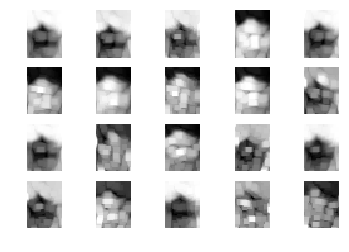

In [17]:
CLayer1=nn.Sequential(nn.Conv2d(1, 20, kernel_size=5, stride=1, padding=0),
            nn.MaxPool2d(kernel_size=4, stride=1))
print(CLayer1)
image = Image.open('foto_random/7_1.jpg').convert("L")
image = transforms_photo(image)
image = image.view(1,1,45,35)
image = Variable(image)
cobavar = Variable(image, volatile=True)
image.size()
fe_value = CLayer1(cobavar)
print(fe_value.shape)
for i in range(20):
    plt.subplot(4,5,i+1);plt.imshow(fe_value[0,i,:,:].cpu().detach().numpy(),cmap='gray');plt.axis('off')

Sequential(
  (0): Conv2d(20, 40, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
)
torch.Size([1, 40, 32, 22])


c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':


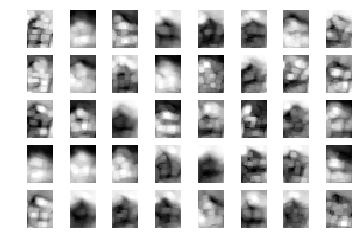

In [18]:
CLayer2=nn.Sequential(
            nn.Conv2d(20, 40, kernel_size=5, stride=1, padding=0),
#             nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1))
print(CLayer2)
image = fe_value
image = image.view(1,20,38,28)
image = image.cpu()
cobavar = Variable(image, volatile=True)
image.size()
fe_value1 = CLayer2(cobavar)
print(fe_value1.shape)
for i in range(40):
    plt.subplot(5,8,i+1);plt.imshow(fe_value1[0,i,:,:].cpu().detach().numpy(),cmap='gray');plt.axis('off')

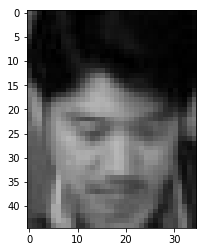

In [45]:
qwrw = Image.open('foto_random/7_1.jpg').convert("L")
plt.imshow(qwrw, cmap='gray', vmin=0, vmax=255)